# Part 3 - Reddit NLP Pre-processing & Modeling

This notebook will focus on using Natural Language Processing to train a classifier on predicting whether a given post came from Anticonsumption subreddit or Minimalism subreddit.

In [296]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, classification
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer

import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import regex as re

from bs4 import BeautifulSoup

In [297]:
import warnings
warnings.filterwarnings('ignore')

### Reading the data

In [298]:
# read the subreddit posts file
subreddit_posts_df = pd.read_csv('./csv_folder/combined_subreddits.csv')

In [299]:
# check first rows
subreddit_posts_df.head()

,subreddit,title,body,created,total_comments,total_upvotes,target,num_title_words,num_title_chars,sentiment
0,Anticonsumption,Great idea,thisisablankpost,2019-10-12 19:26:23,0,3,1,2,10,0.6249
1,Anticonsumption,Erik put a straw through his sippy cup. Dont' ...,thisisablankpost,2019-10-12 17:23:52,5,1,1,12,59,-0.2755
2,Anticonsumption,"Why, just why?",thisisablankpost,2019-10-12 17:13:44,0,0,1,3,14,0.0000
3,Anticonsumption,Local pho shop smooths edges of chipped bowls ...,thisisablankpost,2019-10-12 15:34:28,7,166,1,12,67,0.0000
4,Anticonsumption,Have to agree.,thisisablankpost,2019-10-12 13:44:49,1,39,1,3,14,0.3612


### Pre-processing

Cleaning up features to be used in modeling.
- Remove HTML tags.
- Remove English stop words and custom stop words.
- Remove non-letter characters.
- Make all words lower case.
- Lemmatize words.

In [300]:
custom_stop = list(ENGLISH_STOP_WORDS)
custom_stop.extend(['minimalism', 'minimalist', 'minimal', 'minimalistic', 'anticonsumption', 'consumption', 'life', 
                    'good', 'target', 'reddit', 'subreddit', 'http', 'www', '000', '10', '100', '11', '20', '2019', '24', '30'])

In [301]:
# define a function to clean text from html tags, non-leters, english stop words, custom stop words

def cleanup_lemmatize_text(document):
    # remove HTML
    text = BeautifulSoup(document).get_text()
    # remove non-letter characters
    letters = re.sub("[^a-zA-Z]", " ", document)    
    # all words lower case
    words = letters.lower().split()
    # remove stop words (english + custom)
    stops = set(custom_stop)
    clean_words = [word for word in words if word not in stops]
    # lemmatize cleaned up words
    # lem_clean_words = [lemmatizer.lemmatize(token) for token in clean_words]
    
    # returned the cleand up string
    return(" ".join(clean_words))

Lemmatizing words before modeling dropped my scores 3% in my first 2 models (scroll down to Modeling section to see). It may be because some words that exist in both subreddits in different forms are now equalized. I have commented lemmatizer from my function and will revisit to see how it will perform with my further models.

In [302]:
# initialize an empty list to hold the clean titles
clean_titles = []

for text in subreddit_posts_df['title']:
    # convert title to words, then append to clean_titles list
    clean_titles.append(cleanup_lemmatize_text(text))

In [303]:
len(clean_titles)

7009

In [304]:
subreddit_posts_df.shape

(7009, 10)

In [305]:
subreddit_posts_df['title'] = clean_titles

In [306]:
subreddit_posts_df['title'].head()

0                                           great idea
1                  erik straw sippy cup dont like erik
2                                                 just
3    local pho shop smooths edges chipped bowls kee...
4                                                agree
Name: title, dtype: object

In [307]:
# initialize an empty list to hold the clean posts
clean_posts = []

for text in subreddit_posts_df['body']:
    # convert body to words, then append to clean_posts list
    clean_posts.append(cleanup_lemmatize_text(text))

subreddit_posts_df['body'] = clean_posts

### Modeling

I am planning to generate several Logistic Regression, Multinomial NB, Gaussian NB, Decision Tree, and Random forest estimator models combining with several preprossesing transformers. Using Pipeline and GridSearch will allow me to run several models with least lines of code in order to come up with best combination.  

1- Count Vectorizer & Logistic Regression  
2- Tfidf Vectorizer & Logistic Regression  
3- Count Vectorizer & Multinomial Naive Bayes  
4- Tfidf Vectorizer & Gaussian Naive Bayes    
5- Function Transformer & Count Vectorizer & Logistic Regression (text and numeric data)  
6- Decision Tree  
7- Random Forrest

Set features, split data

In [308]:
# define features variable(s) with only title column
# I will not add body because first subreddit has a lot of blank posts that would cause unbalanced features
X = subreddit_posts_df['title']

# define target variable
y = subreddit_posts_df['target']

In [309]:
# split the data into the training and testing sets
# set a random state for reproducibility 
# stratify y to combat slightly unbalanced classes
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

#### Baseline Model Accuracy

In [310]:
# Baseline accuracy on test data
y_test.value_counts(normalize=True)

1    0.527454
0    0.472546
Name: target, dtype: float64

This means that, if we crate a naive model predicting all posts belong to Anticonsumption subreddit, our model would perform with 53% accuracy. There would be high False Positive rate and low Specifity. 

### Model_1: Count Vectorizer & Logistic Regression

Define pipeline, hyperparameters, and gridsearch.

In [327]:
# CountVectorizer (transformer) & LogisticRegression (estimator)

pipe1 = Pipeline([
        ('cvec', CountVectorizer()),
        ('logreg', LogisticRegression())
])

pipe1_params = {
    'cvec__max_features': [1800, 2000, 2500],
    'cvec__stop_words': [None, 'english'],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'cvec__min_df': [.001, .002],
    'cvec__max_df': [.70, .75, .85],
    'cvec__strip_accents': ['ascii'],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__C': [2, 2.5, 3]
}

gs1 = GridSearchCV(pipe1,  # object to be optimized
                   pipe1_params, # parameter values to be searched
                   cv=5, # 5 folds
                   verbose = 1,
                   n_jobs = -1
                  )

In [328]:
# fit gridsearch CV to train data
gs1.fit(X_train, y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:  2.7min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [329]:
# Number of models generated
print(f"Models count: {3 * 2 * 3 * 2 * 3 * 2 * 5}")

Models count: 1080


In [330]:
# Best score
gs1.best_score_

0.8767035775127768

In [331]:
# Save the best model
gs1_model = gs1.best_estimator_

In [332]:
# Best parameter values
print(f"Model_1 Best parameters: {gs1.best_params_}")

Model_1 Best parameters: {'cvec__max_df': 0.75, 'cvec__max_features': 2200, 'cvec__min_df': 0.001, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': 'english', 'cvec__strip_accents': 'ascii', 'logreg__C': 2.5, 'logreg__penalty': 'l1'}


In [333]:
# Score best model on train set
print(f"Model_1 Train score: {gs1_model.score(X_train, y_train)}")
# Score best model on test set
print(f"Model_1 Test score: {gs1_model.score(X_test, y_test)}")

Model_1 Train score: 0.9356899488926746
Model_1 Test score: 0.9061824470384782


My first model is overfit and suffering from high variance as there is a 3% difference between train data and unseen data. I have set min_df, max_df, and max_features for transformer to cleanup any further noise. Also, lemmatizing words before modeling dropped my scores 3% both in train and test data. It may be because some words that exist in both classes in different forms are now equalized. I have commented lemmatizer from my function and will revisit to see how it will perform with my further models.

### Model_2: TFIDF Vectorizer & Logistic Regression

In [342]:
# TfidfVectorizer (transformer) & LogisticRegression (estimator)

pipe2 = Pipeline([
        ('tvec', TfidfVectorizer()),
        ('logreg', LogisticRegression())
])

pipe2_params = {
    'tvec__max_features': [1300, 1500, 1700],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2), (1,3)],
    'tvec__min_df': [.001, .002],
    'tvec__max_df': [.70, .75, .80, .85],
    'tvec__strip_accents': ['ascii'],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__C': [2, 2.5, 3]
}

gs2 = GridSearchCV(pipe2,  # object to be optimized
                   pipe2_params, # parameter values to be searched
                   cv=5, # 5 folds
                   verbose=1,
                   n_jobs=-1
                  )

In [343]:
# fit gridsearch CV to train data
gs2.fit(X_train, y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   25.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 4320 out of 4320 | elapsed:  3.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('tvec',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                          

In [337]:
# Number of models generated
# print(f"Models count: {3 * 2 * 3 * 2 * 3 * 2 * 5}")

In [338]:
# Best score
gs2.best_score_

0.8705281090289608

In [339]:
# Save the best model
gs2_model = gs2.best_estimator_

In [340]:
# Best parameter values
print(f"Model_2 Best parameters: {gs2.best_params_}")

Model_2 Best parameters: {'logreg__C': 2.5, 'logreg__penalty': 'l1', 'tvec__max_df': 0.8, 'tvec__max_features': 1500, 'tvec__min_df': 0.001, 'tvec__ngram_range': (1, 1), 'tvec__stop_words': None, 'tvec__strip_accents': 'ascii'}


In [341]:
# Score best model on train set
print(f"Model_2 Train score: {gs2_model.score(X_train, y_train)}")
# Score best model on test set
print(f"Model_2 Test score: {gs2_model.score(X_test, y_test)}")

Model_2 Train score: 0.9361158432708688
Model_2 Test score: 0.9009943795936014


My second model is also overfit and suffering from high variance as there is a 4% difference between train data and unseen data. It looks like Tfidf vectorizer model did not outperform Count Vectorizer model as expected. It may be because of some rare words that are the only predictor for the document they belong to lost their influence due to normalization. I have set min_df, max_df, and max_features for transformer to cleanup any further noise.

### Model_3: Count Vectorizer & Multinomial Naive Bayes

In [76]:
# instantiate CountVectorizer object
cv = CountVectorizer()

# fit and transform data
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [396]:
# define hyperparameters
mnb_params = {
    'fit_prior': [True],
    'alpha': [0, 0.5, 1]}
        
#instantate gridsearch
gs_mnb = GridSearchCV(MultinomialNB(),
                    mnb_params,
                    cv = 5,
                    verbose = 1,
                    n_jobs = -1)

In [398]:
# fit train data to model
gs_mnb.fit(X_train_cv, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.0s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': [0, 0.5, 1], 'fit_prior': [True]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=1)

In [407]:
# Save the best model
gs_mnb_model = gs_mnb.best_estimator_

In [409]:
# Best parameter values
print(f"Model_3 Best parameters: {gs_mnb.best_params_}")

Model_3 Best parameters: {'alpha': 0, 'fit_prior': True}


In [410]:
# Score the model on train set
print(f"Model_3 Train score: {gs_mnb_model.score(X_train_cv, y_train)}")
# Score the model on test set
print(f"Model_3 Test score: {gs_mnb_model.score(X_test_cv, y_test)}")

Model_3 Train score: 0.954855195911414
Model_3 Test score: 0.9286640726329443


It looks like Multinomial Naive Bayes is the best model so far. It's less overfit and generalize the information better on test data. Also, it has the lowest time complexity and best memory efficiency. We only created 15 models that took much less time comparing to 1080 models we created earlier with Logistic Regression estimator using pipeline. 

In [419]:
# Generate predictions
preds =gs_mnb_model.predict(X_test_cv)

In [421]:
# Generate confusion matrix
confusion_matrix(y_test, # True values
                 preds)  # Predicted values

array([[1014,   79],
       [  86, 1134]], dtype=int64)

|   |True r/Minimal  | True r/Anticon  |
|---|---|---|
| Pred r/Minimal  | 1014  | 86  |
| Pred r/Anticon  | 79  |1134   |

In [422]:
# Save TN/FP/FN/TP values
tn, fp, fn, tp = confusion_matrix(y_test,
                                  preds).ravel() # .ravel() to arrange items in one-dimensional array

In [423]:
# Calculate specifity
spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

Specificity: 0.9277


In [424]:
# Calculate sensitivity
sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

Sensitivity: 0.9295


In [426]:
# create a dataframe that contains
# 1. The list of true values of our test set
# 2. The list of predicted probabilities based on our model

# P(Y = 1)
pred_proba = [i[1] for i in gs_mnb_model.predict_proba(X_test_cv)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

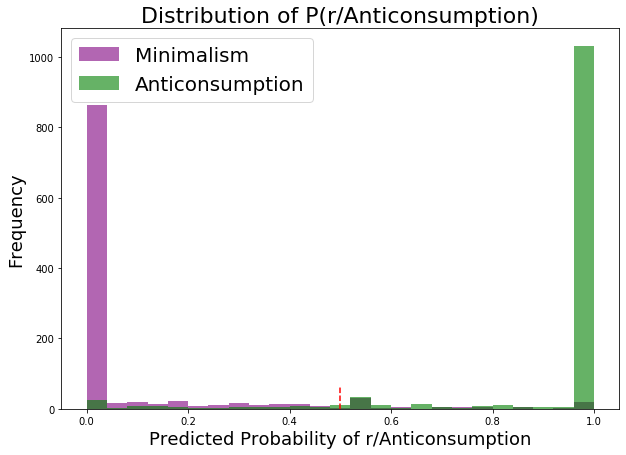

In [435]:
# This code is copied from lecture 4.04 starter code with slight modifications
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='purple',
         alpha = 0.6,
         label='Minimalism')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='green',
         alpha = 0.6,
         label='Anticonsumption')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 65,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(r/Anticonsumption)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability of r/Anticonsumption', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

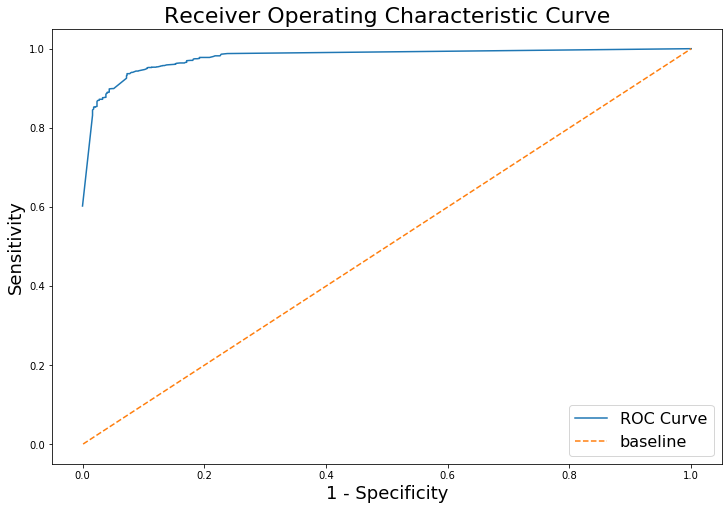

In [441]:
# This code is adopted from lecture 4.04 starter code with further modifications

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))

# Create threshold values.
thresholds = np.linspace(0, 1, 200) 
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Define function to plot ROC curve
def plot_roc_curve(tpr_list, fpr_list): 
    plt.figure(figsize=(12,8))
    plt.plot(fpr_list, # False Positive Rate on X-axis
             tpr_list, # True Positive Rate on Y-axis
             label='ROC Curve')
    plt.plot(np.linspace(0, 1, 200), # Plot baseline.
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')
    plt.title('Receiver Operating Characteristic Curve', fontsize=22)
    plt.ylabel('Sensitivity', fontsize=18) # Label y axes.
    plt.xlabel('1 - Specificity', fontsize=18) # Label x axes.
    plt.legend(fontsize=16);  # Create legend.

plot_roc_curve(tpr_values, fpr_values);

### Model_4: Tfidf Vectorizer & Gaussian Naive Bayes

In [79]:
# instantiate CountVectorizer object
tv = TfidfVectorizer()

# fit and transform data
X_train_tv = tv.fit_transform(X_train)
X_test_tv = tv.transform(X_test)

In [80]:
# instantiate GaussianNB object
gnb = GaussianNB()

# fit train data to model
# as the data is a sparse matrix, convert to array to make it dense
gnb.fit(X_train_tv.toarray(), y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [81]:
# Score the model on train set
print(f"Model_4 Train score: {gnb.score(X_train_tv.toarray(), y_train)}")
# Score the model on test set
print(f"Model_4 Test score: {gnb.score(X_test_tv.toarray(), y_test)}")

Model_4 Train score: 0.9248296422487223
Model_4 Test score: 0.9009943795936014


Gaussian Naive Bayes is also a candidate to be the best model in terms of low variance and high performance. There is only 2% difference in accuracy between train and test data and it predicts 91% of the document classes correctly.

### Model_5: Logistic Regression (Text & Numeric)

I will use feature union with pipeline to fit num_title_words, total_upvotes, and sentiment numeric variables as well as words to my model. Text features will be vectorized, whereas numeric features will not be teansformed.

In [270]:
# set X and y
# this time we will include some numeric features to see their impact
X_union = subreddit_posts_df[['title', 'num_title_words', 'total_upvotes', 'sentiment']]
y_union = subreddit_posts_df['target']

In [271]:
# split the data
X_union_train, X_union_test, y_union_train, y_union_test = train_test_split(X_union, y_union, test_size=0.33, 
                                                                               stratify=y, random_state=42)

In [272]:
# create functions to group features based on data type
def get_text(data):
    return data['title']

def get_numeric(data):
    return data[['num_title_words', 'total_upvotes', 'sentiment']]

In [273]:
# create function transformer for text features
get_text_tf = FunctionTransformer(get_text, validate=False)
# create function transformer for numeric features
get_numeric_tf = FunctionTransformer(get_numeric, validate=False)

In [274]:
# create the new pipeline
pipe3 = Pipeline([
    # feature union
    ('union', FeatureUnion([
        # numeric
        ('numeric', get_numeric_tf),
        # text
        ('text', Pipeline([
            # extract text
            ('selector', get_text_tf),
            # vectorize
            ('cvec', CountVectorizer())
        ]))
    ])),
    # model
    ('logreg', LogisticRegression())
])

In [275]:
pipe3_params = {}

In [276]:
gs3 = GridSearchCV(pipe3, pipe3_params, cv=5)

In [277]:
gs3.fit(X_union_train, y_union_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('union',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('numeric',
                                                                        FunctionTransformer(accept_sparse=False,
                                                                                            check_inverse=True,
                                                                                            func=<function get_numeric at 0x00000268DC0B11F8>,
                                                                                            inv_kw_args=None,
                                                                                            inverse_func=None,
                                                                                            kw_args=None,
          

In [278]:
# Score the model on train set
print(f"Model_5 Train score: {gs3.score(X_union_train, y_union_train)}")
# Score the model on test set
print(f"Model_5 Test score: {gs3.score(X_union_test, y_union_test)}")

Model_5 Train score: 0.9723168654173765
Model_5 Test score: 0.9485516645049719


In [279]:
# save the best model
gs3_model = gs3.best_estimator_

In [280]:
# extract the coefficients of all features from the model
gs3_coefs = gs3_model.named_steps['logreg'].coef_[0]

In [281]:
# extract the count-vectorized title features from the model
text_features = gs3_model.named_steps['union'].transformer_list[1][1].named_steps['cvec'].get_feature_names()

In [282]:
# define numeric features list
numeric_features = ['num_title_words', 'total_upvotes', 'sentiment']

# combine numeric and text features
# since we have passed numeric features first to the feature union, they should be the first ones in the list
features = numeric_features + text_features

In [283]:
# create a dictionary for features and coefficient pairs
model5_coef_dict = dict(zip(features, gs3_coefs))

In [284]:
# convert feature/coefficent pairs to dataframe
model5_coef_df = pd.DataFrame(model5_coef_dict.items(), columns=['feature', 'coef'])

In [285]:
# top 15 positive coefficients
model5_coef_df.sort_values('coef', ascending=False).head(15).T

,2367,117,3526,448,2248,3636,669,3603,47,573,1603,3518,3618,3236,1876
feature,plastic,anti,water,capitalism,packaging,years,consumer,world,ad,climate,individually,waste,wrapped,thought,lord
coef,2.83577,2.21274,1.94987,1.89525,1.87345,1.79223,1.76443,1.71502,1.69668,1.693,1.68534,1.66275,1.62001,1.60592,1.53244


In [286]:
# top 15 negative coefficients
model5_coef_df.sort_values('coef').head(15).T

,3504,584,822,122,2713,820,1308,3225,1286,303,1748,803,2580,2407,2505
feature,wardrobe,clutter,decluttering,anxiety,rid,declutter,furniture,therapy,friends,birthday,kitchen,deal,recently,possessions,purchased
coef,-2.13777,-2.0346,-1.93209,-1.91986,-1.91359,-1.66246,-1.6096,-1.56801,-1.54521,-1.53476,-1.53371,-1.52225,-1.51675,-1.49064,-1.42628


In [287]:
# save top 50 features to dataframe
top_50_features_df = pd.concat([model5_coef_df.sort_values('coef', ascending=False).head(25),
                             model5_coef_df.sort_values('coef').head(25)])

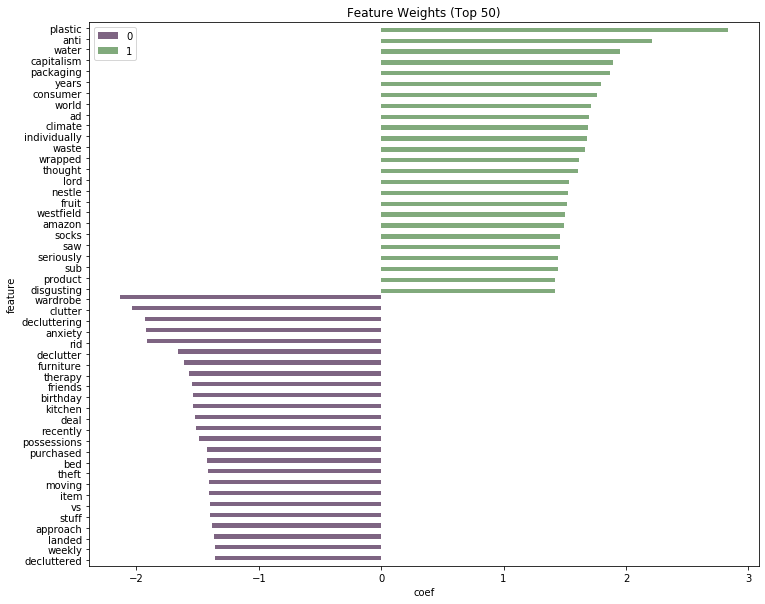

In [288]:
plt.subplots(figsize=(12, 10))
colors = [1 if c >= 0 else 0 for c in coef]
palette = sns.xkcd_palette(['dusty purple','faded green'])
sns.barplot(x="coef", y="feature", data=top_50_features_df,
            hue=colors, palette=palette).set_title('Feature Weights (Top 50)');

#### Interpreting numeric feature coefficients

In [292]:
model5_coef_df.head(3)

,feature,coef
0,num_title_words,0.005666
1,total_upvotes,0.001879
2,sentiment,-0.597937


In [293]:
# sentiment
np.exp(-0.597937)

0.549945003165458

As composite sentiment score increases by 1, the post is about 55% as likely to belong to r/Anticonsumption subreddit.

In [294]:
# total upvotes
np.exp(0.001879)

1.0018807664266987

As upvotes increases by 1, the post is about 1.00188 more likely to belong to r/Anticonsumption subreddit. (It means there is not much difference between two subreddits)


In [295]:
# number of words in title
np.exp(0.005666)

1.00568208213745

As upvotes increases by 1, the post is about 1.005682 more likely to belong to r/Anticonsumption subreddit. (It means there is not much difference between two subreddits)

In [351]:
# Generate predictions.
gs3_model.named_steps

{'union': FeatureUnion(n_jobs=None,
              transformer_list=[('numeric',
                                 FunctionTransformer(accept_sparse=False,
                                                     check_inverse=True,
                                                     func=<function get_numeric at 0x00000268DC0B11F8>,
                                                     inv_kw_args=None,
                                                     inverse_func=None,
                                                     kw_args=None,
                                                     pass_y='deprecated',
                                                     validate=False)),
                                ('text',
                                 Pipeline(memory=None,
                                          steps=[('selector',
                                                  FunctionTransformer(accept_sparse=False,
                                                                 

### Model_6: Decision Tree & Count Vectorizer

In [392]:
# CountVectorizer (transformer) & DecisionTreeClassifier (estimator)

pipe4 = Pipeline([
        ('cvec', CountVectorizer()),
        ('dt', DecisionTreeClassifier())
])

pipe4_params = {
    'cvec__ngram_range': [(1,1), (1,2)],
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_depth': [120, 136, 175],
    'dt__min_samples_split': [7, 8, 10],
    'dt__max_features': [None, 'log2', 'auto'],
    }

gs4 = GridSearchCV(pipe4,  # object to be optimized
                   pipe4_params, # parameter values to be searched
                   cv=5, # 5 folds
                   verbose = 1,
                   n_jobs = -1)

In [393]:
gs4.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 315 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 525 out of 540 | elapsed:   15.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   15.7s finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [395]:
# Best score
gs4.best_score_

0.815587734241908

In [394]:
# Score the model on train set
print(f"Model_6 Train score: {gs4.score(X_train, y_train)}")
# Score the model on test set
print(f"Model_6 Test score: {gs4.score(X_test, y_test)}")

Model_6 Train score: 0.8856473594548552
Model_6 Test score: 0.83873757025508


In [391]:
# Best parameter values
print(f"Model_4 Best parameters: {gs4.best_params_}")

Model_4 Best parameters: {'cvec__ngram_range': (1, 1), 'dt__criterion': 'gini', 'dt__max_depth': 136, 'dt__max_features': None, 'dt__min_samples_split': 7}


My sixth model was initially underfit with 68% accuracy with a max_depth value of 54. I have gradually increased the depth value to optimize the performance. The best max_depth value is 136 with a better accuracy of 84% on test data. However k-folds score is relatively less and the model is overfit. Even though decision tree algorithms have a lot of advantages such as high speed, less preprocessing work, interpretability etc., they often suffer from high error due to variance. It needs more time and numerous trials to optimize the hyperparameters to get the best results. "No free lunch."

### Conclusion

The best models are Model_3 (Multinomial Naive Bayes) and Model_4 (Logistic Regression with numerical features). The accuracy rate on test data (.33 split) is respectively